# README
수정해야 하는 변수는 모두 hyper-param에서 args로 관리

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# random seed를 적용하기 위함
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## [C] 모델 생긴거 이쁘게 출력 (선택사항)

In [62]:
# !pip install pytorch-model-summary
# from pytorch_model_summary import summary
# !pip install transformers

In [63]:
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
from glob import glob
import math

import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# hyper-param
관리를 쉽게 하기 위해 hyper-param은 모두 args 객체로 관리   
그 밖에 환경에 따라 바꿔야 하는 변수도 모두 args로 관리   

In [65]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# random
args.seed = 42

# path
args.dataset_dir = "/content/drive/MyDrive/Colab_Notebooks/lpms/data"
# weight 저장용 폴더의 path(없으면 만드셈)
args.weight_dir = "/content/drive/MyDrive/Colab_Notebooks/lpms/model_weight"

# train
args.epoch = 50
args.batch_size = 32
args.lr = 1e-4

## random 통제 (시연 위함)   
https://dacon.io/en/forum/407713

In [66]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["PYTHONHASHSEED"] = str(args.seed)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# 데이터셋 분할 (훈련 : 검증 : 평가 = 8 : 1 : 1)
train_dataset, val_dataset 모두 impact, non-imact 데이터가 균일하게 분포하게끔 코드를 변경함(train_test_split 함수에서 stratify option 이용)

In [67]:
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = labels
        if len(self.data_dir) != len(self.labels): raise RuntimeError("data_dir size and label size is different")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_dir, label = self.data_dir[idx], self.labels[idx]
        image_tensors = []

        # img_dir 폴더 내의 모든 png 파일을 순회
        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name)
            image = Image.open(img_path).convert('RGB')  # 이미지 열기 및 RGB로 변환

            if self.transform:
                image = self.transform(image)

            image_tensors.append(image)

        if image_tensors:
            images_tensor = torch.stack(image_tensors)

        return images_tensor, label

In [92]:
X, y = [], []
for idx, val in enumerate(glob(args.dataset_dir+'/**')):
    for j in glob(val+'/**'):
        if y.count(idx^1) >= 170: break
        X.append(j)
        y.append(1 if idx==0 else 0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=args.seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=args.seed)

print(f"0_train_label : 1_train_label = {y_train.count(0)}: {y_train.count(1)}")
print(f"0_val_label : 1_val_label = {y_val.count(0)}: {y_val.count(1)}")
print(f"0_test_label : 1_test_label = {y_test.count(0)}: {y_test.count(1)}")

0_train_label : 1_train_label = 133: 136
0_val_label : 1_val_label = 17: 17
0_test_label : 1_test_label = 17: 17


In [93]:
y_train.count(0)

133

In [117]:
for i in range(len(X_test)):
    print(X_test[i], y_test[i])

/content/drive/MyDrive/Colab_Notebooks/lpms/data/impact/HB5_LPMS_Impact_Test_2021-04-15_15-51-47(46M225SG2)_HB5_LPMS_00002_CH12_0 0
/content/drive/MyDrive/Colab_Notebooks/lpms/data/not_impact/HB5_LPMS_False_Alarm_10-20_10-35-24_LPMS_E_17_52G_211020000413 1
/content/drive/MyDrive/Colab_Notebooks/lpms/data/not_impact/HB5_LPMS_False_Alarm_10-20_10-35-24_LPMS_E_16_37G_211020000251 1
/content/drive/MyDrive/Colab_Notebooks/lpms/data/not_impact/HB5_LPMS_False_Alarm_10-20_10-35-24_LPMS_E_17_31G_211020000083 1
/content/drive/MyDrive/Colab_Notebooks/lpms/data/not_impact/HB5_LPMS_False_Alarm_10-20_10-35-24_LPMS_E_17_12G_211020000222 1
/content/drive/MyDrive/Colab_Notebooks/lpms/data/impact/HB5_LPMS_Impact_Test_2021-04-15_17-30-01(64B270SG2)_HB5_LPMS_00002_CH13_0 0
/content/drive/MyDrive/Colab_Notebooks/lpms/data/impact/HB5_LPMS_Impact_Test_2021-04-15_15-44-36(45M180SG2)_HB5_LPMS_00004_CH12_0 0
/content/drive/MyDrive/Colab_Notebooks/lpms/data/not_impact/HB5_LPMS_False_Alarm_10-20_10-35-24_LPMS_E_1

In [95]:
# 데이터 전처리 및 증강
transform = transforms.Compose([
    # [C] 학습의 효율성을 위해 dataset을 300x300으로 미리 변환함
    # transforms.Resize((224, 224)),
    # [C] 돌아가서나 뒤집히면 안되는 데이터
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_fn(batch):
    # batch: list of (image, label)
    images, labels = zip(*batch)
    # Convert images to tensors and stack them into a batch
    images = [image.clone().detach() for image in images]
    seq_len = [image.shape[0] for image in images]
    images = torch.nn.utils.rnn.pad_sequence(images, batch_first=True)
    labels = torch.tensor(labels)
    seq_len = torch.tensor(seq_len)
    return images, labels, seq_len

In [96]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

# 모델 로드
1에 가까울 수록 impact data   
https://justkode.kr/data-science/just-data-science-11/

In [105]:
class CNNRNNModel(nn.Module):
    def __init__(self, rnn_hidden_size, num_classes):
        super(CNNRNNModel, self).__init__()

        # Pretrained ResNet-18 모델을 사용하여 CNN 구성
        cnn_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        layers = list(cnn_model.children())[:-1]  # 마지막 레이어 제거
        self.cnn = nn.Sequential(*layers)

        # LSTM 설정: input_size는 CNN의 출력 크기
        self.rnn = nn.LSTM(input_size=512, hidden_size=rnn_hidden_size, batch_first=True)

        # Fully Connected Layer 설정
        self.fc = nn.Linear(rnn_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()  # Sigmoid 활성화 함수 추가

    def forward(self, x, lengths):
        # x의 크기: (batch_size, seq_len, c, h, w)
        batch_size, seq_len, c, h, w = x.size()

        # CNN을 적용하기 위해 크기를 변환: (batch_size * seq_len, c, h, w)
        c_in = x.view(batch_size * seq_len, c, h, w)

        # CNN 적용: (batch_size * seq_len, 512, 1, 1)
        c_out = self.cnn(c_in)

        # RNN의 입력으로 사용하기 위해 크기를 변환: (batch_size, seq_len, 512*7*7)
        r_in = c_out.view(batch_size, seq_len, -1)

        # 시퀀스 길이에 따라 패킹
        packed_input = pack_padded_sequence(r_in, lengths, batch_first=True, enforce_sorted=False)

        # LSTM 적용
        packed_output, (h_n, c_n) = self.rnn(packed_input)

        # 패킹 해제
        r_out, _ = pad_packed_sequence(packed_output, batch_first=True)
        r_out = r_out[range(r_out.shape[0]), lengths - 1, :]

        r_out = self.fc(r_out)

        # Sigmoid 활성화 함수 적용
        out = self.sigmoid(r_out)

        return out

# 모델 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNRNNModel(rnn_hidden_size=64, num_classes=1)  # 이진 분류의 경우 num_classes=1
model = model.to(device)
device

device(type='cuda', index=0)

# 손실 함수 및 옵티마이저 설정

In [106]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(len(train_loader) * args.epoch * 0.1),
    num_training_steps=(len(train_loader) * args.epoch)
)

In [107]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum().item()
    return acc

In [108]:
cur_dir = args.weight_dir+f"/weight_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)
    print(f"모델의 weight를 저장하기 위한 디렉토리 생성: {cur_dir}")
else:
    print(f"디렉토리 이미 존재함: {cur_dir}")

모델의 weight를 저장하기 위한 디렉토리 생성: /content/drive/MyDrive/Colab_Notebooks/lpms/model_weight/weight_2024-06-24_22-05-46


# validation

In [109]:
# return validation loss
def validate():
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels, seq_lengths in val_loader:
            # [C] label이 integer면 MSE 쓸 때 오류남
            images, labels = images.to(device), labels.to(device).float().view(-1,1)

            outputs = model(images, seq_lengths)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += binary_accuracy(outputs, labels)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
    return avg_val_loss, avg_val_acc

# train

In [110]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
def train():
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels, seq_lengths in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float().view(-1,1)

        optimizer.zero_grad()

        outputs = model(images, seq_lengths)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        running_acc += binary_accuracy(outputs, labels)

    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_train_acc = running_acc / len(train_loader.dataset)

    return avg_train_loss, avg_train_acc

# 결과

In [111]:
list_epoch = []
list_train_loss = []
list_train_acc = []
list_val_loss = []
list_val_acc = []
list_lr = []

In [112]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
for epoch in tqdm(range(1, args.epoch+1)):
    print(f"\n epoch: {epoch}")
    avg_train_loss, avg_train_acc = train()
    avg_val_loss, avg_val_acc = validate()

    list_epoch.append(epoch)
    list_train_loss.append(avg_train_loss)
    list_train_acc.append(avg_train_acc)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_acc)
    list_lr.append(scheduler.get_last_lr()[0])

    # 학습된 모델 가중치 저장
    print(f"train_loss: {avg_train_loss}, train_acc: {avg_train_acc}")
    print(f"val_loss: {avg_val_loss}, val_acc: {avg_val_acc}")
    torch.save(model.state_dict(), cur_dir+f"/{epoch}_{avg_train_loss}.pth")

  0%|          | 0/50 [00:00<?, ?it/s]


 epoch: 1



  2%|▏         | 1/50 [21:15<17:21:58, 1275.89s/it]

train_loss: 0.6609341894383767, train_acc: 0.7063197026022305
val_loss: 0.5683699109975029, val_acc: 0.9117647058823529

 epoch: 2



  4%|▍         | 2/50 [21:36<7:10:06, 537.64s/it]  

train_loss: 0.4388300929370866, train_acc: 0.9888475836431226
val_loss: 0.3469289190628949, val_acc: 1.0

 epoch: 3



  6%|▌         | 3/50 [21:57<3:56:23, 301.78s/it]

train_loss: 0.27241417926261857, train_acc: 1.0
val_loss: 0.21710816025733948, val_acc: 1.0

 epoch: 4



  8%|▊         | 4/50 [22:18<2:26:22, 190.93s/it]

train_loss: 0.16951650613745792, train_acc: 1.0
val_loss: 0.1346884913304273, val_acc: 1.0

 epoch: 5



 10%|█         | 5/50 [22:39<1:37:15, 129.67s/it]

train_loss: 0.11141520422852172, train_acc: 1.0
val_loss: 0.09073321258320528, val_acc: 1.0

 epoch: 6



 12%|█▏        | 6/50 [23:01<1:08:06, 92.86s/it] 

train_loss: 0.07218921010046643, train_acc: 1.0
val_loss: 0.06447628973161473, val_acc: 1.0

 epoch: 7



 14%|█▍        | 7/50 [23:22<49:45, 69.42s/it]  

train_loss: 0.054826431599580665, train_acc: 1.0
val_loss: 0.05121148684445549, val_acc: 1.0

 epoch: 8



 16%|█▌        | 8/50 [23:43<37:54, 54.15s/it]

train_loss: 0.046014563730990575, train_acc: 1.0
val_loss: 0.04473726407569997, val_acc: 1.0

 epoch: 9



 18%|█▊        | 9/50 [24:05<29:57, 43.84s/it]

train_loss: 0.04089202831558136, train_acc: 1.0
val_loss: 0.039743651581161166, val_acc: 1.0

 epoch: 10



 20%|██        | 10/50 [24:26<24:37, 36.95s/it]

train_loss: 0.03624598699929989, train_acc: 1.0
val_loss: 0.03523923916851773, val_acc: 1.0

 epoch: 11



 22%|██▏       | 11/50 [24:47<20:53, 32.13s/it]

train_loss: 0.03253537202496289, train_acc: 1.0
val_loss: 0.0315090058480992, val_acc: 1.0

 epoch: 12



 24%|██▍       | 12/50 [25:08<18:13, 28.77s/it]

train_loss: 0.028839187634257135, train_acc: 1.0
val_loss: 0.028269736205830294, val_acc: 1.0

 epoch: 13



 26%|██▌       | 13/50 [25:29<16:18, 26.44s/it]

train_loss: 0.026626269655045966, train_acc: 1.0
val_loss: 0.026239193099386552, val_acc: 1.0

 epoch: 14



 28%|██▊       | 14/50 [25:51<14:55, 24.87s/it]

train_loss: 0.02499648412779583, train_acc: 1.0
val_loss: 0.024785254150629044, val_acc: 1.0

 epoch: 15



 30%|███       | 15/50 [26:12<13:55, 23.88s/it]

train_loss: 0.02356363607217388, train_acc: 1.0
val_loss: 0.0235441292033476, val_acc: 1.0

 epoch: 16



 32%|███▏      | 16/50 [26:34<13:05, 23.10s/it]

train_loss: 0.022421668730260715, train_acc: 1.0
val_loss: 0.022418480585603154, val_acc: 1.0

 epoch: 17



 34%|███▍      | 17/50 [26:55<12:21, 22.48s/it]

train_loss: 0.02123509424298891, train_acc: 1.0
val_loss: 0.0213285336161361, val_acc: 1.0

 epoch: 18



 36%|███▌      | 18/50 [27:16<11:45, 22.06s/it]

train_loss: 0.02036529277420177, train_acc: 1.0
val_loss: 0.02048024973448585, val_acc: 1.0

 epoch: 19



 38%|███▊      | 19/50 [27:37<11:16, 21.84s/it]

train_loss: 0.019953677818511498, train_acc: 1.0
val_loss: 0.019702837528551325, val_acc: 1.0

 epoch: 20



 40%|████      | 20/50 [27:58<10:47, 21.59s/it]

train_loss: 0.019096665444427265, train_acc: 1.0
val_loss: 0.019117032561232063, val_acc: 1.0

 epoch: 21



 42%|████▏     | 21/50 [28:19<10:22, 21.45s/it]

train_loss: 0.01883280280714363, train_acc: 1.0
val_loss: 0.018654459320447025, val_acc: 1.0

 epoch: 22



 44%|████▍     | 22/50 [28:41<10:00, 21.46s/it]

train_loss: 0.018247432937520146, train_acc: 1.0
val_loss: 0.018241819651687845, val_acc: 1.0

 epoch: 23



 46%|████▌     | 23/50 [29:02<09:40, 21.50s/it]

train_loss: 0.017743304385682463, train_acc: 1.0
val_loss: 0.017800810692064902, val_acc: 1.0

 epoch: 24



 48%|████▊     | 24/50 [29:24<09:17, 21.46s/it]

train_loss: 0.017578490196162883, train_acc: 1.0
val_loss: 0.017386816442012787, val_acc: 1.0

 epoch: 25



 50%|█████     | 25/50 [29:45<08:54, 21.39s/it]

train_loss: 0.017108206481406235, train_acc: 1.0
val_loss: 0.016972323989166933, val_acc: 1.0

 epoch: 26



 52%|█████▏    | 26/50 [30:06<08:33, 21.39s/it]

train_loss: 0.016510345048676194, train_acc: 1.0
val_loss: 0.01653750131235403, val_acc: 1.0

 epoch: 27



 54%|█████▍    | 27/50 [30:27<08:07, 21.21s/it]

train_loss: 0.016132278894126193, train_acc: 1.0
val_loss: 0.0160629373482045, val_acc: 1.0

 epoch: 28



 56%|█████▌    | 28/50 [30:48<07:46, 21.19s/it]

train_loss: 0.015644759140548654, train_acc: 1.0
val_loss: 0.01562234211493941, val_acc: 1.0

 epoch: 29



 58%|█████▊    | 29/50 [31:09<07:25, 21.20s/it]

train_loss: 0.015024308194873723, train_acc: 1.0
val_loss: 0.01518667401636348, val_acc: 1.0

 epoch: 30



 60%|██████    | 30/50 [31:31<07:04, 21.25s/it]

train_loss: 0.014703732413208617, train_acc: 1.0
val_loss: 0.01483270843677661, val_acc: 1.0

 epoch: 31



 62%|██████▏   | 31/50 [31:52<06:43, 21.22s/it]

train_loss: 0.014407567274808662, train_acc: 1.0
val_loss: 0.014610976199893391, val_acc: 1.0

 epoch: 32



 64%|██████▍   | 32/50 [32:13<06:21, 21.21s/it]

train_loss: 0.014177191919442889, train_acc: 1.0
val_loss: 0.014417586300302954, val_acc: 1.0

 epoch: 33



 66%|██████▌   | 33/50 [32:34<05:59, 21.16s/it]

train_loss: 0.014037712664104527, train_acc: 1.0
val_loss: 0.014266883187434253, val_acc: 1.0

 epoch: 34



 68%|██████▊   | 34/50 [32:55<05:37, 21.12s/it]

train_loss: 0.01394464866323985, train_acc: 1.0
val_loss: 0.014159762245767257, val_acc: 1.0

 epoch: 35



 70%|███████   | 35/50 [33:16<05:17, 21.16s/it]

train_loss: 0.013762166540114189, train_acc: 1.0
val_loss: 0.014011474764522384, val_acc: 1.0

 epoch: 36



 72%|███████▏  | 36/50 [33:37<04:55, 21.11s/it]

train_loss: 0.013620564738309296, train_acc: 1.0
val_loss: 0.013879535171915503, val_acc: 1.0

 epoch: 37



 74%|███████▍  | 37/50 [33:59<04:34, 21.12s/it]

train_loss: 0.013670964942047144, train_acc: 1.0
val_loss: 0.013824543751337948, val_acc: 1.0

 epoch: 38



 76%|███████▌  | 38/50 [34:19<04:12, 21.06s/it]

train_loss: 0.013414617510145482, train_acc: 1.0
val_loss: 0.013728627168080387, val_acc: 1.0

 epoch: 39



 78%|███████▊  | 39/50 [34:41<03:51, 21.07s/it]

train_loss: 0.0133961493488692, train_acc: 1.0
val_loss: 0.013691400342127857, val_acc: 1.0

 epoch: 40



 80%|████████  | 40/50 [35:02<03:31, 21.11s/it]

train_loss: 0.0133394109895349, train_acc: 1.0
val_loss: 0.013596935088143629, val_acc: 1.0

 epoch: 41



 82%|████████▏ | 41/50 [35:23<03:10, 21.19s/it]

train_loss: 0.013207915149019775, train_acc: 1.0
val_loss: 0.013537347535876668, val_acc: 1.0

 epoch: 42



 84%|████████▍ | 42/50 [35:45<02:50, 21.32s/it]

train_loss: 0.013203334229475503, train_acc: 1.0
val_loss: 0.013492264291819404, val_acc: 1.0

 epoch: 43



 86%|████████▌ | 43/50 [36:06<02:29, 21.31s/it]

train_loss: 0.013187833666995333, train_acc: 1.0
val_loss: 0.013454452595290016, val_acc: 1.0

 epoch: 44



 88%|████████▊ | 44/50 [36:27<02:07, 21.28s/it]

train_loss: 0.01312183223484728, train_acc: 1.0
val_loss: 0.013455859659349216, val_acc: 1.0

 epoch: 45



 90%|█████████ | 45/50 [36:48<01:46, 21.26s/it]

train_loss: 0.013100654911596092, train_acc: 1.0
val_loss: 0.013436316019471954, val_acc: 1.0

 epoch: 46



 92%|█████████▏| 46/50 [37:10<01:24, 21.21s/it]

train_loss: 0.013187076868731737, train_acc: 1.0
val_loss: 0.013410075622446397, val_acc: 1.0

 epoch: 47



 94%|█████████▍| 47/50 [37:31<01:03, 21.15s/it]

train_loss: 0.013126364393249764, train_acc: 1.0
val_loss: 0.013397351345595191, val_acc: 1.0

 epoch: 48



 96%|█████████▌| 48/50 [37:52<00:42, 21.18s/it]

train_loss: 0.013163715441707784, train_acc: 1.0
val_loss: 0.013379805666558883, val_acc: 1.0

 epoch: 49



 98%|█████████▊| 49/50 [38:13<00:21, 21.12s/it]

train_loss: 0.013100931583644067, train_acc: 1.0
val_loss: 0.013386528281604542, val_acc: 1.0

 epoch: 50



100%|██████████| 50/50 [38:34<00:00, 46.29s/it]

train_loss: 0.013085763479087876, train_acc: 1.0
val_loss: 0.013369805453454746, val_acc: 1.0


# 결과 그래프

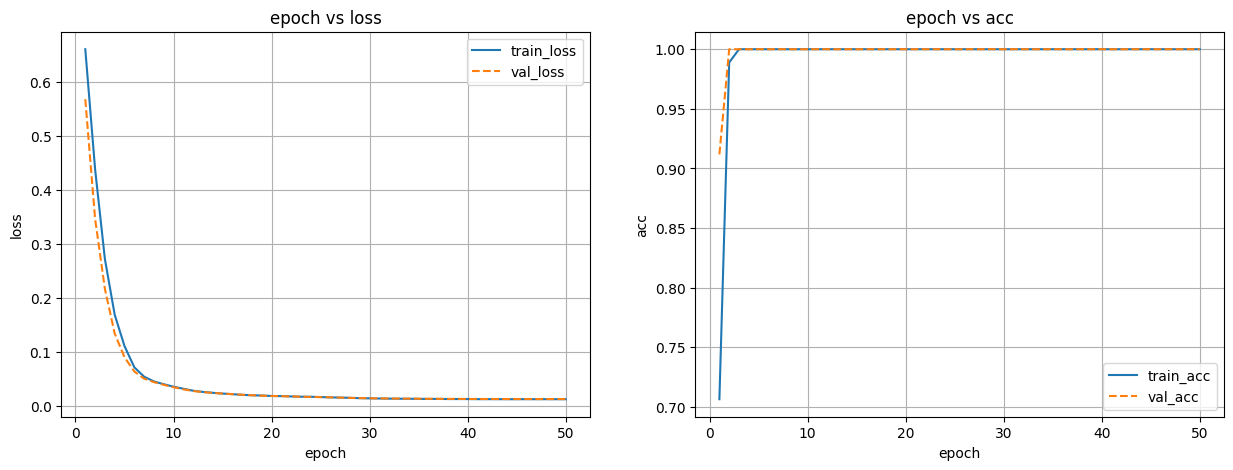

In [113]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
# ax1.set_ylim([1000, 2000])
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== accuracy Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_acc, label='train_acc')
ax2.plot(list_epoch, list_val_acc, '--', label='val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')

plt.savefig(cur_dir+"matrix.png", dpi=400)

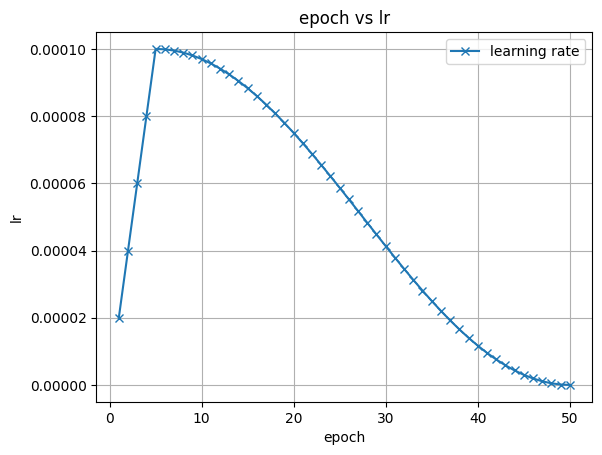

In [114]:
plt.plot(list_epoch, list_lr, marker='x', label='learning rate')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.grid()
plt.legend()
plt.title('epoch vs lr')
plt.legend()
plt.savefig(cur_dir+"lr.png", dpi=400)

# Eval

In [116]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels, seq_lengths in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device).view(-1,1)

        outputs = model(images, seq_lengths)
        total += labels.size(0)
        correct += binary_accuracy(outputs, labels)

accuracy = (correct / total)*100
print(accuracy)

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

100.0
